In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/kaggle
#Check the present working directory using pwd command

/content/kaggle


In [ ]:
!kaggle datasets download -d splcher/animefacedataset

 99% 391M/395M [00:06<00:00, 87.4MB/s]
100% 395M/395M [00:06<00:00, 65.7MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [ ]:
import glob
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import cv2
import scipy
from PIL import Image
import matplotlib.gridspec as gridspec
from keras.layers import Conv2D, Dense, Conv2DTranspose, Flatten, Reshape, Input, BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [ ]:
filenames = glob.glob('/content/kaggle/images/*')

In [ ]:
len(filenames)

63565

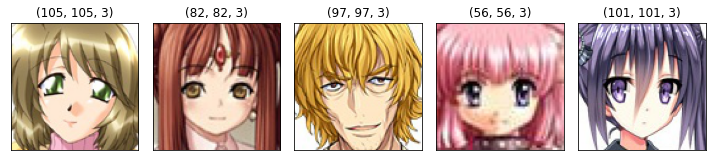

In [ ]:
idx = np.random.randint(0, len(filenames), 5)
imgs = []

for i in idx :
  imgs.append(plt.imread(filenames[i]))

plt.figure(figsize = (10, 8))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(imgs[i])
  plt.title(imgs[i].shape)
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()


In [ ]:
# HELPER FUNCTIONS
def norm_img(img):
  img = img.astype('float32')
  img = (img/127.5) - 1 # lies between [-1 1]
  return img

def denorm_img(img):
  img = 127.5*(img + 1) # returns the real pixels unnormalized
  img = img.astype('uint8')
  return img

In [ ]:
train_imgs = []
for f in filenames:
  img = Image.open(f)
  img = img.resize((64, 64))
  img = img.convert('RGB')
  img = np.asarray(img)
  img = norm_img(img)
  train_imgs.append(img)

train_imgs = np.array(train_imgs)

In [ ]:
def sample_from_dataset(batch_size = 256, show = False):
  idx = np.random.randint(0, len(filenames)-1, batch_size)
  imgs = train_imgs[idx]
    
  if show :
    plt.figure(figsize = (10, 8))
    for i in range(5):
      plt.subplot(1, 5, i+1)
      plt.imshow(denorm_img(imgs[i]))
      plt.title(imgs[i].shape)
      plt.xticks([])
      plt.yticks([])

    plt.tight_layout()
    plt.show()

  return np.array(imgs)

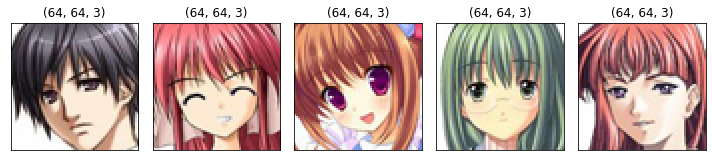

In [ ]:
x = sample_from_dataset(batch_size=10, show = True)

In [ ]:
def build_generator():
  inputs = Input(shape= (1, 1, 100))
  x = Conv2DTranspose(512, (4, 4), (1, 1), padding = 'valid')(inputs)
  x = LeakyReLU(alpha = 0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2DTranspose(256, (4, 4), (2, 2), padding = 'same')(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2DTranspose(128, (4, 4), (2, 2), padding = 'same')(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2DTranspose(64, (4, 4), (2, 2), padding = 'same')(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2D(64, (3, 3), (1, 1), padding = 'same')(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  outputs = Conv2DTranspose(3, (4, 4), (2, 2), padding = 'same', activation = 'tanh')(x)

  opt = Adam(lr = 0.0002, beta_1 = 0.5 )
  model = Model(inputs, outputs)
  model.compile(loss = 'binary_crossentropy', optimizer = opt)
  model.summary()

  return model

In [ ]:
def build_discriminator():
  inputs = Input((64, 64, 3))

  x = Conv2D(64, (4, 4), (2 ,2), padding = 'same')(inputs)
  x = LeakyReLU(0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2D(128, (4, 4), (2 ,2), padding = 'same')(x)
  x = LeakyReLU(0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2D(256, (4, 4), (2 ,2), padding = 'same')(x)
  x = LeakyReLU(0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2D(512, (4, 4), (2 ,2), padding = 'same')(x)
  x = LeakyReLU(0.2)(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Flatten()(x)
  
  
  outputs = Dense(1, activation = 'sigmoid')(x)

  opt = Adam(lr = 0.0002, beta_1 = 0.5 )
  model = Model(inputs, outputs)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
  model.summary()

  return model

In [ ]:
def generate_noise(batch_size):
  noise = np.random.normal(0, 1, size=(batch_size, 1, 1, 100))
  return noise

In [ ]:
def train(epochs = 1000, batch_size = 256, save_interval = 100):

  for epoch in range(epochs):
    # sample from dataset to train discriminator
    half_batch = batch_size//2
    imgs = sample_from_dataset(half_batch)

    # generate noise to fool distriminator
    noise = generate_noise(half_batch)
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = generate_noise(batch_size)
    valid_y = np.array([1]*batch_size)

    g_loss = combined.train_on_batch(noise, valid_y)

    # Printing status
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
      save_imgs(epoch)


In [ ]:
def save_imgs(epochs):
  r, c = 4, 4
  noise = generate_noise(r*c)
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5 

  fig, axes = plt.subplots(r, c)
  cnt = 0

  for i in range(r):
    for j  in range(c):
      axes[i, j].imshow(gen_imgs[cnt])
      axes[i, j].axis('off')
      cnt += 1

  fig.savefig('/content/drive/MyDrive/GAN_ANIME/generated_images/img_%d.png' % epochs)
  plt.close()

In [ ]:
optimizer = Adam(0.0002, beta_1 = 0.5)
discriminator = build_discriminator()
#discriminator = keras.models.load_model('/content/drive/MyDrive/GAN_ANIME/models/discriminator.h5')
#generator = keras.models.load_model('/content/drive/MyDrive/GAN_ANIME/models/generator.h5')
generator = build_generator()
# now lets make a combined model
inputs = Input((1, 1, 100))
img = generator(inputs)

discriminator.trainble = False

valid = discriminator(img)
combined = Model(inputs, valid)
combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 128)       512 

In [ ]:
train(epochs = 1200, batch_size = 512, save_interval = 50)

0 [D loss: 0.281040, acc.: 71.09%] [G loss: 1.250652]
1 [D loss: 0.351300, acc.: 79.30%] [G loss: 1.043801]
2 [D loss: 0.397407, acc.: 73.24%] [G loss: 0.953211]
3 [D loss: 0.409976, acc.: 65.23%] [G loss: 0.920257]
4 [D loss: 0.410613, acc.: 62.70%] [G loss: 0.906520]
5 [D loss: 0.409144, acc.: 60.55%] [G loss: 0.901958]
6 [D loss: 0.413874, acc.: 56.45%] [G loss: 0.912598]
7 [D loss: 0.412110, acc.: 60.74%] [G loss: 0.901133]
8 [D loss: 0.398461, acc.: 60.74%] [G loss: 0.919083]
9 [D loss: 0.406482, acc.: 59.18%] [G loss: 0.919835]
10 [D loss: 0.423341, acc.: 70.51%] [G loss: 0.936723]
11 [D loss: 0.418391, acc.: 73.83%] [G loss: 0.958957]
12 [D loss: 0.439295, acc.: 73.44%] [G loss: 0.969740]
13 [D loss: 0.416805, acc.: 75.59%] [G loss: 0.963964]
14 [D loss: 0.416070, acc.: 71.68%] [G loss: 0.937703]
15 [D loss: 0.408789, acc.: 69.92%] [G loss: 0.906977]
16 [D loss: 0.410729, acc.: 60.35%] [G loss: 0.918869]
17 [D loss: 0.417783, acc.: 64.26%] [G loss: 0.929746]
18 [D loss: 0.411152

In [ ]:
# generator.save('/content/drive/MyDrive/GAN_ANIME/models/generator.h5')
# discriminator.save('/content/drive/MyDrive/GAN_ANIME/models/discriminator.h5')
# combined.save('/content/drive/MyDrive/GAN_ANIME/models/combined.h5')

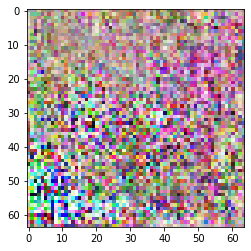

In [ ]:
generator = keras.models.load_model('/content/drive/MyDrive/GAN_ANIME/models/generator.h5')
noise = generate_noise(1)
img = generator.predict(noise)
img = 0.5*img + 0.5
plt.imshow(img[0])